# Calculating MCD DTW(Mel cepstral distortion - Dynamic time warping)

Mel cepstral distortion is an objective measure of speech quality. This notebook calculates MCD between a tts generated audio and a ground truth audio. Closer the mcd value is to zero, closer the simlarity between two audios. MCD of an audio with itself will result in a value of 0.

MCD DTW is a modification of MCD that works with non aligned audio clips by using dynamic time warping cost matrix.Tthe scale depends on factors such as mel extractor and reduction algorithm(mean of DTW cost or min DTW path cost). These limitations render this metric useless for a comprehensive evaluation, however it is useful for comparing the model convergence. The models trained on similar mels can be compared with respect to ground truth, to get the model with better convergence.


In [1]:
## Import libraries
import librosa
import librosa.display
import numpy as np
import math
import matplotlib.pyplot as plt
import os

In [2]:
## Mel params
n_fft=2048
hop_length=512
win_length=None
window='hann'
n_mels = 34

## Mfcc params
n_mfcc=n_mels

### Load and Visualize data
For the purpose of this tutorial, we will first apply DTW on single file from two models to understand the metric and later take the average mcd over more few files from each model.

In [3]:
# Load files
gt_file = "orig.wav"
synt_file = "synt.wav"

## Load wavs
gt_wav, gt_sr = librosa.load(gt_file)
synt_wav, synt_sr = librosa.load(synt_file)

Text(0.5, 1.0, 'model1')

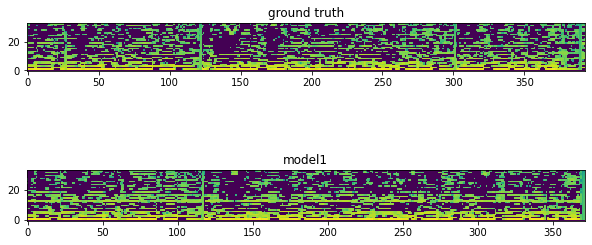

In [4]:
%%capture --no-display
## Generate spectrograms
gt_mels = librosa.feature.melspectrogram(gt_wav, sr=gt_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, n_mels=n_mels)
synt_mels = librosa.feature.melspectrogram(synt_wav, sr=gt_sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, n_mels=n_mels)
## Convert Mel specs to log scale
gt_mels = librosa.power_to_db(gt_mels, ref=np.max)
synt_mels = librosa.power_to_db(synt_mels, ref=np.max)


## Generate MFCC
gt_mfcc = librosa.feature.mfcc(S=gt_mels, n_mfcc=n_mfcc)
synt_mfcc = librosa.feature.mfcc(S=synt_mels, n_mfcc=n_mfcc)
##Convert MFCC to log scale
gt_mfcc = librosa.power_to_db(gt_mfcc, ref=np.max)
synt_mfcc = librosa.power_to_db(synt_mfcc, ref=np.max)


fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(2, 1)
ax[0].imshow(gt_mfcc, origin="lower", interpolation='nearest')
ax[1].imshow(synt_mfcc, origin="lower", interpolation='nearest')

ax[0].set_title("ground truth")
ax[1].set_title("model1")

In [5]:
## Define the cost function for calculating DTW
def log_spec_dB_dist(x, y):
    log_spec_dB_const = 10.0 / math.log(10.0) * math.sqrt(2.0)
    diff = x - y
    return log_spec_dB_const * math.sqrt(np.inner(diff, diff))

### Calculate DTW matrix
We will use [DTW function from librosa](https://librosa.org/doc/main/generated/librosa.sequence.dtw.html) on MFCC. It returns DTW cost matrix and DTW path.

In [6]:
frames = synt_mels.shape[1]
mcd = 0
dtw_cost, dtw_min_path = librosa.sequence.dtw(gt_mfcc, synt_mfcc, metric=log_spec_dB_dist)

Reduction of DTW matrix can be done by either taking a mean of entire cost matrix or averaging DTW cost for the mininum cost path per frame. We will use the DTW cost along the min cost path.

In [7]:
path_cost_matrix = dtw_cost[dtw_min_path[:, 0], dtw_min_path[:, 1]]
path_cost = np.sum(path_cost_matrix)
path_length = dtw_min_path.shape[0]
reduced_dtw_cost = path_cost/path_length

mcd = reduced_dtw_cost/frames

print(f"MCD_DTW is: {mcd}")

MCD_DTW is: 598.0785362803024


## MCD_DTW usecase

MCD is a very useful metric to compare the convergence of two models. Therefore in this section we will calcaulate the average MCD for files from each model. We will first put the above calculations in functions for better readability.

In [8]:
def get_mfcc(filename):
    wav, sr = librosa.load(filename)
    
    mels = librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, n_mels=n_mels)
    mels_db = librosa.power_to_db(mels, ref=np.max)
    
    mfcc = librosa.feature.mfcc(S=mels_db, n_mfcc=n_mfcc)
    mfcc_db = librosa.power_to_db(mfcc, ref=np.max)
    
    return mfcc_db, mels_db

In [9]:
def extract_path_cost(D, wp):
    """
    Get the path cost from D(cost matrix), wp (warped path)
    :returns: sum of path cost 
    """
    path_cost = D[wp[:, 0], wp[:, 1]]
    return np.sum(path_cost)

def extract_frame_avg_path_cost(D, wp):
    path_cost = extract_path_cost(D, wp)
    path_length = wp.shape[0]
    frame_avg_path_cost = path_cost / float(path_length)
    return frame_avg_path_cost
 

In [10]:
def cal_mcd(gt_mfcc, synt_mfcc, cost_function, dtw_type='path_cost'):
    frames = synt_mfcc.shape[1]
    path_cost = 0
    
    # dynamic time warping for MCD
    dtw_cost, dtw_min_path = librosa.sequence.dtw(gt_mfcc, synt_mfcc, metric=cost_function)
    if dtw_type == 'mean':
        path_cost = np.mean(dtw_cost)
    else:
        path_cost = extract_frame_avg_path_cost(dtw_cost, dtw_min_path)
    
    mcd = path_cost / frames
    
    return mcd, frames

In [11]:
def cal_mcd_dir(synt_dir, gt_dir):
    mcds = []
    
    synt_filenames = os.listdir(synt_dir)
    synt_filepaths = [os.path.join(synt_dir, filename) for filename in synt_filenames]
    synt_filepaths.sort()
    gt_filenames = os.listdir(gt_dir)
    gt_filepaths = [os.path.join(gt_dir, filename) for filename in gt_filenames]
    gt_filepaths.sort()

    for synt_audio, gt_audio in zip(synt_filepaths, gt_filepaths):
        synt_mfcc, synt_mel = get_mfcc(synt_audio)
        gt_mfcc, gt_mel = get_mfcc(gt_audio)
        
        mcd, _ = cal_mcd(gt_mfcc, synt_mfcc, log_spec_dB_dist)
        mcds.append(mcd)
    return mcds

### Calculate MCD DTW on synthesized files from each model

In [12]:
%%capture --no-display
audio_dir_m1 = "model1/"
audio_dir_m2 = "model2/"
audio_dir_gt = "orig/"

mcds_m1 = cal_mcd_dir(audio_dir_m1, audio_dir_gt)
mcds_m2 = cal_mcd_dir(audio_dir_m2, audio_dir_gt)

In [13]:
print(f"Average MCD for model 1 is: {sum(mcds_m1)/len(mcds_m1):.2f}")
print(f"Average MCD for model 2 is: {sum(mcds_m2)/len(mcds_m2):.2f}")

Average MCD for model 1 is: 577.51
Average MCD for model 2 is: 597.42


### Plotting MCD

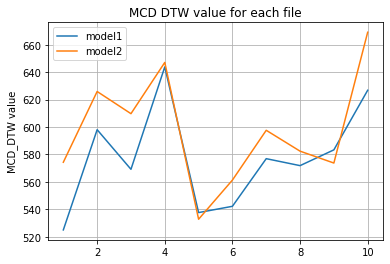

In [14]:
x_axis = np.linspace(1, len(mcds_m1), 10)
plt.plot(x_axis, mcds_m1, label="model1")
plt.plot(x_axis, mcds_m2, label="model2")

plt.title("MCD DTW value for each file")
plt.ylabel("MCD_DTW value")

plt.grid()
plt.legend()
plt.show()

## Conclusion

From the graph above and the average MCD across files. We can conclude that model1 has better convergence than model2. MCD is a great tool to analyse the model convergence. But, the final quality of model cannot be trusted based on MCD as it tends to pleateaus with more training and difference between two MCD values is not usually very high.